# **LB_Neural_Network_Testing**

---

**Article Title:** Engineering Nonlinear Optical Activation Functions for All-Optical Neural Networks

**Authors:**  
- Xinzhe Xu\* (Purdue University)  
- Ruben Canora\* (Purdue University)  

\*Equal contribution  

**Advisors:** 
- Shengwang Du (Advisor, Purdue University)
- Hadiseh Alaeian (Advisor, Purdue University)  


**Date:** November 2024  
**License:** MIT License

---

## **Objective**

This notebook contains simulations and analysis for the research paper "Engineering Nonlinear Optical Activation Functions for All-Optical Neural Networks Based on Three-Level Atomic Ensemble." Specifically, this notebook focuses on testing the accuracy of the simulated EIT curve on the task of image classification.

---

### Import Required Libraries
Import necessary libraries such as numpy, matplotlib, scipy, and ipywidgets.

In [1]:
# Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import ipywidgets as widgets
from IPython.display import display

### Define Constants and Initialize Variables
Define constants like Gamma3, L, z, k_0, epsilon_0, hbar, N, mu_23, mu_13, and initialize variables like Transparency_Omega_1, Transparency_Omega_2, Om_2_list_adapted.

In [3]:
# Define Constants and Initialize Variables

# Define constants
Gamma3 = 1.0  # Example value, replace with actual value
L = 10.0  # Length in some units, replace with actual value
z = 0.1  # Step size in some units, replace with actual value
k_0 = 1.0  # Example value, replace with actual value
epsilon_0 = 8.854e-12  # Permittivity of free space in F/m
hbar = 1.0545718e-34  # Reduced Planck's constant in J·s
N = 1.0  # Example value, replace with actual value
mu_23 = 1.0  # Example value, replace with actual value
mu_13 = 1.0  # Example value, replace with actual value

# Initialize variables
Transparency_Omega_1 = None
Transparency_Omega_2 = None
Om_2_list_adapted = None

In [4]:
# Constants
epsilon_0 = 8.854e-12  # Vacuum permittivity (F/m)
hbar = 1.054e-34       # Reduced Planck's constant (J·s)
mu_13 = 1.932e-29      # Dipole moment between states |1> and |3> (C·m)
mu_23 = 2.53e-29       # Dipole moment between states |2> and |3> (C·m)
N = 3.5e10             # Atomic number density (atoms/m^3)

Gamma3 = 2 * np.pi * 6   # (MHz)
Gamma31 = 5/9 * Gamma3   # Decay from level 3 to level 1 (MHz)
Gamma32 = Gamma23 = 4/9 * Gamma3   # Decay from level 3 to level 2 (MHz)
Gamma12 = Gamma21 = 0.05 * Gamma3    # Decay rates between levels 1 and 2 (MHz)
gamma13 = (Gamma3 + Gamma12)/2  # Decoherence rate between levels 1 and 3 (MHz)
gamma23 = (Gamma3 + Gamma21)/2  # Decoherence rate between levels 2 and 3 (MHz)
gamma12 = (Gamma12 + Gamma21)/2     # Decoherence rate between ground states (MHz)

w_1 = 2 * np.pi * 3e8 / 795e-9
k_0 = w_1 / 3e8
L = 0.1        # Length in meters
z = 0.00005    # Step size in meters

### Define Backend Function to Calculate OD
Define the function calculate_OD_1 to calculate optical density based on user input.

In [5]:
# Define Backend Function to Calculate OD
def calculate_OD_1(Om_1=1.0, delta_1=0.0, delta_2=0.0):
    n_rabi = 500
    Om_2_list_adapted = np.linspace(0.005, 12, n_rabi, dtype=complex)  # Coupling Rabi frequency range (dimensionless)
    Om_2_list = Om_2_list_adapted * Gamma3
    Om_1_list = np.full(n_rabi, Om_1 * Gamma3, dtype=complex)
    
    nz = int(L / z)  # Number of z steps
    z_array = np.arange(nz) * z  # Array of z values
    
    # Initialize arrays to store Rabi frequencies at each z step
    Om_2_vs_z = []
    Om_1_vs_z = []

    # Initialize arrays with zeros to store populations
    rho11_values = np.zeros((nz, n_rabi), dtype=float)
    rho22_values = np.zeros((nz, n_rabi), dtype=float)
    rho33_values = np.zeros((nz, n_rabi), dtype=float)
    
    rho11_values[0, :] = 1.0
    rho22_values[0, :] = 0.0
    rho33_values[0, :] = 0.0

    # Initialize arrays to store rho31 and rho32
    rho31_values = np.zeros((nz, n_rabi), dtype=complex)
    rho32_values = np.zeros((nz, n_rabi), dtype=complex)

    for i in range(nz):
        if i == nz/4 or i == nz/2 or i == 3*nz/4: 
            print(f"Processing z step {i}/{nz}")
        
        for j in range(1, len(Om_2_list)):
            Om_2_actual = Om_2_list[j]      # Convert to actual Omega_2 in MHz
            Om_1_actual = Om_1_list[j]      # Convert Om_1 to MHz

            delta_1_actual = delta_1 * Gamma3
            delta_2_actual = delta_2 * Gamma3

            # Construct A and b as per Code2
            # Define the imaginary unit
            I = 1j

            # Construct the matrix A
            A = np.array([
                # Row 1
                [Gamma31 + Gamma12, 0, I*Om_1_actual/2, 0, Gamma31 - Gamma21, 0, -I*np.conjugate(Om_1_actual)/2, 0],
                # Row 2
                [0, gamma12 - I*(delta_2_actual - delta_1_actual), I*Om_2_actual/2, 0, 0, 0, 0, -I*np.conjugate(Om_1_actual)/2],
                # Row 3
                [I*np.conjugate(Om_1_actual), I*np.conjugate(Om_2_actual)/2, gamma13 + I*delta_1_actual, 0, I*np.conjugate(Om_1_actual)/2, 0, 0, 0],
                # Row 4
                [0, 0, 0, gamma12 + I*(delta_2_actual - delta_1_actual), 0, I*Om_1_actual/2, -I*np.conjugate(Om_2_actual)/2, 0],
                # Row 5
                [Gamma32 - Gamma12, 0, 0, 0, Gamma32 + Gamma21, I*Om_2_actual/2, 0, -I*np.conjugate(Om_2_actual)/2],
                # Row 6
                [I*np.conjugate(Om_2_actual)/2, 0, 0, I*np.conjugate(Om_1_actual)/2, I*np.conjugate(Om_2_actual), gamma23 + I*delta_2_actual, 0, 0],
                # Row 7
                [-I*Om_1_actual, 0, 0, -I*Om_2_actual/2, -I*Om_1_actual/2, 0, gamma13 - I*delta_1_actual, 0],
                # Row 8
                [-I*Om_2_actual/2, -I*Om_1_actual/2, 0, 0, -I*Om_2_actual, 0, 0, gamma23 - I*delta_2_actual]
            ], dtype=complex)
            
            # Construct the vector b
            b = np.array([
                Gamma31,
                0,
                I*np.conjugate(Om_1_actual)/2,
                0,
                Gamma32,
                I*np.conjugate(Om_2_actual)/2,
                -I*Om_1_actual/2,
                -I*Om_2_actual/2
            ], dtype=complex)
            
            # Solve the linear system A * v = b
            try:
                v = np.linalg.solve(A, b)
            except np.linalg.LinAlgError:
                # Handle singular matrix
                print("nan")
                rho11_values[i][j] = np.nan
                rho22_values[i][j] = np.nan
                rho33_values[i][j] = np.nan
                rho31_values[i][j] = np.nan
                rho32_values[i][j] = np.nan
                continue

            # Extract the solutions
            rho11 = np.real(v[0])
            rho12 = v[1]
            rho13 = v[2]
            rho21 = v[3]
            rho22 = np.real(v[4])
            rho23 = v[5]
            rho31 = v[6]
            rho32 = v[7]

            # Compute rho33
            rho33 = 1 - rho11 - rho22

            # Store the populations
            rho11_values[i][j] = np.real(rho11)
            rho22_values[i][j] = np.real(rho22)
            rho33_values[i][j] = np.real(rho33)
            rho31_values[i][j] = rho31
            rho32_values[i][j] = rho32
            

            # Update the Rabi frequencies
            Om_2_list[j] = Om_2_actual + z * (1j) * (k_0 / (epsilon_0 * hbar)) * N * rho32 * mu_23**2
            Om_1_list[j] = Om_1_actual + z * (1j) * (k_0 / (epsilon_0 * hbar)) * N * rho31 * mu_13**2

        # Record Rabi frequencies at this z step
        Om_2_vs_z.append(Om_2_list.copy())
        Om_1_vs_z.append(Om_1_list.copy())
    
    # Convert lists to numpy arrays
    Om_2_vs_z = np.array(Om_2_vs_z)  # Shape: (nz, n_rabi)
    Om_1_vs_z = np.array(Om_1_vs_z)
    
    return Om_2_list_adapted, Om_2_list, Om_1_list, rho11_values, rho22_values, rho33_values, rho31_values, rho32_values, Om_2_vs_z, Om_1_vs_z, z_array

### Define Plotting Function
Define the function plot_OD to plot the output intensity of Omega_1 and Omega_2 based on the calculated values.

In [6]:
# Define Plotting Function
def plot_OD(Om_1, delta_1, delta_2):
    global Transparency_Omega_1, Transparency_Omega_2, Om_2_list_adapted
    global stored_Om_2_list_adapted, stored_Output_Intensity_Omega_1, stored_Output_Intensity_Omega_2
    
    Om_2_list_adapted, Om_2_list, Om_1_list, rho11_values, rho22_values, rho33_values, rho31_values, rho32_values, Om_2_vs_z, Om_1_vs_z, z_array = calculate_OD_1(Om_1, delta_1, delta_2)
   
    Om_2_vs_z_dimensionless = Om_2_vs_z / Gamma3
    Om_1_vs_z_dimensionless = Om_1_vs_z / Gamma3
    
    # Compute transparency for Omega_1 and Omega_2
    Transparency_Omega_1 = np.abs(Om_1_vs_z[-1, :])**2 / np.abs(Om_1_vs_z[0, :])**2
    Transparency_Omega_2 = np.abs(Om_2_vs_z[-1, :])**2 / np.abs(Om_2_vs_z[0, :])**2

    # Calculate output intensity based on transparency and initial input power
    Output_Intensity_Omega_1 = Transparency_Omega_1 * np.abs(Om_1_vs_z[0, :])**2 / (Gamma3**2)
    Output_Intensity_Omega_2 = Transparency_Omega_2 * np.abs(Om_2_vs_z[0, :])**2 / (Gamma3**2)
    
    # Store values for curve fitting
    stored_Om_2_list_adapted = np.real(Om_2_list_adapted)**2
    stored_Output_Intensity_Omega_1 = Output_Intensity_Omega_1
    stored_Output_Intensity_Omega_2 = Output_Intensity_Omega_2
    
    # Plot Output Intensity of Omega_1 vs Initial Omega_2
    plt.figure(figsize=(8, 6))
    plt.plot(stored_Om_2_list_adapted, Output_Intensity_Omega_1, color='blue', label='Output Intensity $\Omega_1$')
    plt.xlabel('Initial Intensity 2 ($I_{in} / (\\Gamma_3)^2$)')
    plt.ylabel('Output Intensity 1 ($I_{out} / (\\Gamma_3)^2$)')
    plt.title(f'Output Intensity 1 vs $I_{{2,\t{{in}}}} / (\\Gamma_3)^2$ for 'f'$\\Omega_1/\\Gamma_3={Om_1}$, 'f'$\\Delta_1/\\Gamma_3={delta_1}$, 'f'$\\Delta_2/\\Gamma_3={delta_2}$')
    plt.grid(True)
    plt.show()

    # Plot Output Intensity of Omega_2 vs Initial Omega_2
    plt.figure(figsize=(8, 6))
    plt.plot(stored_Om_2_list_adapted, Output_Intensity_Omega_2, color='red', label='Output Intensity $\Omega_2$')
    plt.xlabel('Initial Intensity 2 ($I_{in} / (\\Gamma_3)^2$)')
    plt.ylabel('Output Intensity 2 ($I_{out} / (\\Gamma_3)^2$)')
    plt.title(f'Output Intensity 2 vs $I_{{2,\t{{in}}}} / (\\Gamma_3)^2$ for 'f'$\\Omega_1/\\Gamma_3={Om_1}$, 'f'$\\Delta_1/\\Gamma_3={delta_1}$, 'f'$\\Delta_2/\\Gamma_3={delta_2}$')
    plt.grid(True)
    plt.show()

### Create Interactive Widgets
Create interactive widgets using ipywidgets for Om_1, delta_1, delta_2, and a button to run the simulation.

In [7]:
# Create Interactive Widgets

# Adjust slider description width specifically
slider_layout = widgets.Layout(width='800px')  # Adjust slider width if needed
description_layout = widgets.Layout(width='150px')  # Adjust description width

# Interactive sliders for Om_1, delta_1, delta_2 with wider description layout
Om_1_slider = widgets.FloatSlider(
    value=3, min=0.000001, max=10.0, step=0.01,
    description='$\Omega_1$ (MHz)', layout=slider_layout,
    style={'description_width': '150px'}  # This sets description width
)

delta_1_slider = widgets.FloatSlider(
    value=0.50, min=-1.5, max=1.5, step=0.01,
    description='$\Delta_1$ (MHz)', layout=slider_layout,
    style={'description_width': '150px'}  # Adjust description width
)

delta_2_slider = widgets.FloatSlider(
    value=0.0, min=-1.5, max=1.5, step=0.01,
    description='$\Delta_2$ (MHz)', layout=slider_layout,
    style={'description_width': '150px'}  # Adjust description width
)

# Create the button to start the simulation
run_button = widgets.Button(
    description="Run Simulation",
    button_style='success',  # 'success', 'info', 'warning', 'danger' or '' (default)
    tooltip='Click to run the simulation',
    icon='play'
)

# Function to be triggered when the button is clicked
def run_simulation(b):
    # Extract the current slider values
    Om_1 = Om_1_slider.value
    delta_1 = delta_1_slider.value
    delta_2 = delta_2_slider.value
    
    # Call the plot_OD function with these values
    plot_OD(Om_1, delta_1, delta_2)

# Attach the function to the button
run_button.on_click(run_simulation)

# Display the sliders and the button
display(Om_1_slider, delta_1_slider, delta_2_slider, run_button)

FloatSlider(value=3.0, description='$\\Omega_1$ (MHz)', layout=Layout(width='800px'), max=10.0, min=1e-06, ste…

FloatSlider(value=0.5, description='$\\Delta_1$ (MHz)', layout=Layout(width='800px'), max=1.5, min=-1.5, step=…

FloatSlider(value=0.0, description='$\\Delta_2$ (MHz)', layout=Layout(width='800px'), max=1.5, min=-1.5, step=…

Button(button_style='success', description='Run Simulation', icon='play', style=ButtonStyle(), tooltip='Click …

### Curve Fit the Plot
Use scipy's curve_fit function to fit the stored plot values to a function and display the fitted curve.

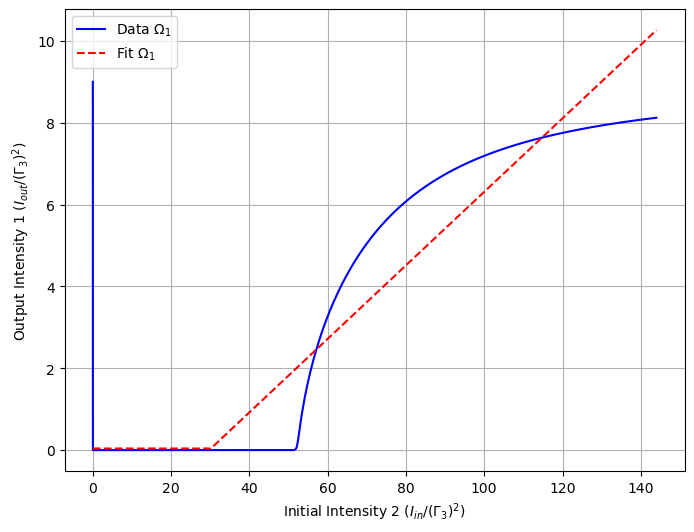

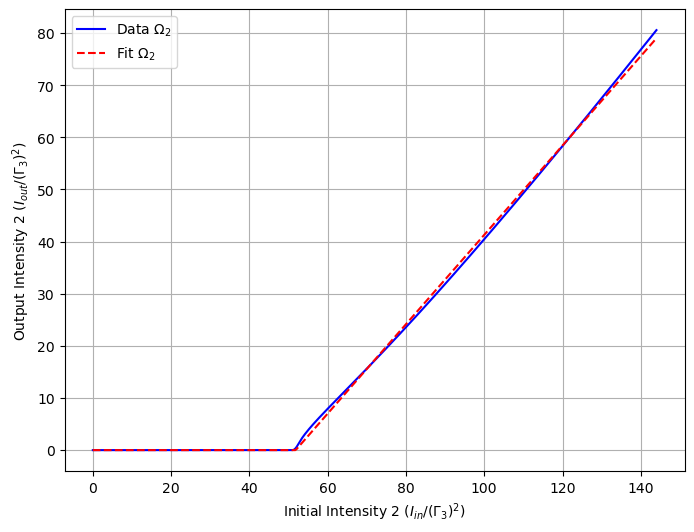

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the ReLU-like function
def relu_like_function(x, a, b, c):
    return a * np.maximum(0, x - b) + c

# Perform curve fitting for Omega_1 with increased maxfev
popt_Omega_1, pcov_Omega_1 = curve_fit(relu_like_function, stored_Om_2_list_adapted, stored_Output_Intensity_Omega_1, maxfev=5000)
fitted_Omega_1 = relu_like_function(stored_Om_2_list_adapted, *popt_Omega_1)

# Perform curve fitting for Omega_2 with increased maxfev
popt_Omega_2, pcov_Omega_2 = curve_fit(relu_like_function, stored_Om_2_list_adapted, stored_Output_Intensity_Omega_2, maxfev=5000)
fitted_Omega_2 = relu_like_function(stored_Om_2_list_adapted, *popt_Omega_2)

# Plot the fitted curves
plt.figure(figsize=(8, 6))
plt.plot(stored_Om_2_list_adapted, stored_Output_Intensity_Omega_1, 'b-', label='Data $\Omega_1$')
plt.plot(stored_Om_2_list_adapted, fitted_Omega_1, 'r--', label='Fit $\Omega_1$')
plt.xlabel('Initial Intensity 2 ($I_{in} / (\\Gamma_3)^2$)')
plt.ylabel('Output Intensity 1 ($I_{out} / (\\Gamma_3)^2$)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(stored_Om_2_list_adapted, stored_Output_Intensity_Omega_2, 'b-', label='Data $\Omega_2$')
plt.plot(stored_Om_2_list_adapted, fitted_Omega_2, 'r--', label='Fit $\Omega_2$')
plt.xlabel('Initial Intensity 2 ($I_{in} / (\\Gamma_3)^2$)')
plt.ylabel('Output Intensity 2 ($I_{out} / (\\Gamma_3)^2$)')
plt.legend()
plt.grid(True)
plt.show()

Fitted parameters: a=0.85719545483159, b=51.83156628913262, c=0.0012710534192285044


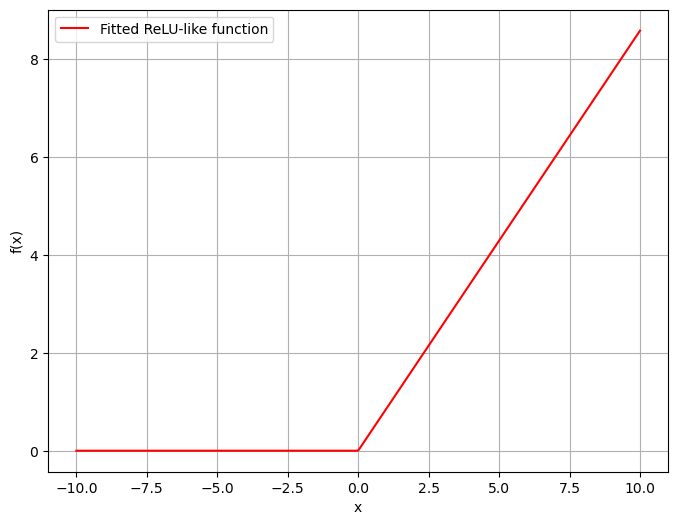

In [40]:
# extract the fitted parameters
a_Omega_1, b_Omega_1, c_Omega_1 = popt_Omega_2
print(f"Fitted parameters: a={a_Omega_1}, b={b_Omega_1}, c={c_Omega_1}")
# plotting the fitted parameters
def relu_like_function(x, a, b, c):
    return a * np.maximum(0, x - b) + c

# plot the relu like function with the fitted parameters
plt.figure(figsize=(8, 6))
x_values = np.linspace(-10, 10, 500)
y_values = relu_like_function(x_values, a_Omega_1, 0, c_Omega_1)

plt.plot(x_values, y_values, 'r-', label='Fitted ReLU-like function')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)
plt.show()


Fitted parameters: a = 0.8572, b = 51.8316, c = 0.0013
SimpleNN(
  (fc1): Linear(in_features=144, out_features=25, bias=True)
  (custom_relu): CustomReLU()
  (fc2): Linear(in_features=25, out_features=10, bias=True)
)
Epoch [1/30], Loss: 2.3022, Accuracy: 10.97%
Epoch [2/30], Loss: 2.3016, Accuracy: 11.24%
Epoch [3/30], Loss: 2.3016, Accuracy: 11.24%
Epoch [4/30], Loss: 2.3016, Accuracy: 11.24%
Epoch [5/30], Loss: 2.3016, Accuracy: 11.18%
Epoch [6/30], Loss: 2.3014, Accuracy: 11.21%
Epoch [7/30], Loss: 2.3016, Accuracy: 11.22%
Epoch [8/30], Loss: 2.3016, Accuracy: 11.20%
Epoch [9/30], Loss: 2.3016, Accuracy: 11.24%
Epoch [10/30], Loss: 2.3016, Accuracy: 11.24%
Epoch [11/30], Loss: 2.3016, Accuracy: 11.20%
Epoch [12/30], Loss: 2.3016, Accuracy: 11.24%
Epoch [13/30], Loss: 2.3015, Accuracy: 11.13%
Epoch [14/30], Loss: 2.3016, Accuracy: 11.24%
Epoch [15/30], Loss: 2.3015, Accuracy: 11.24%
Epoch [16/30], Loss: 2.3017, Accuracy: 11.24%
Epoch [17/30], Loss: 2.3015, Accuracy: 11.20%
Epoch [18

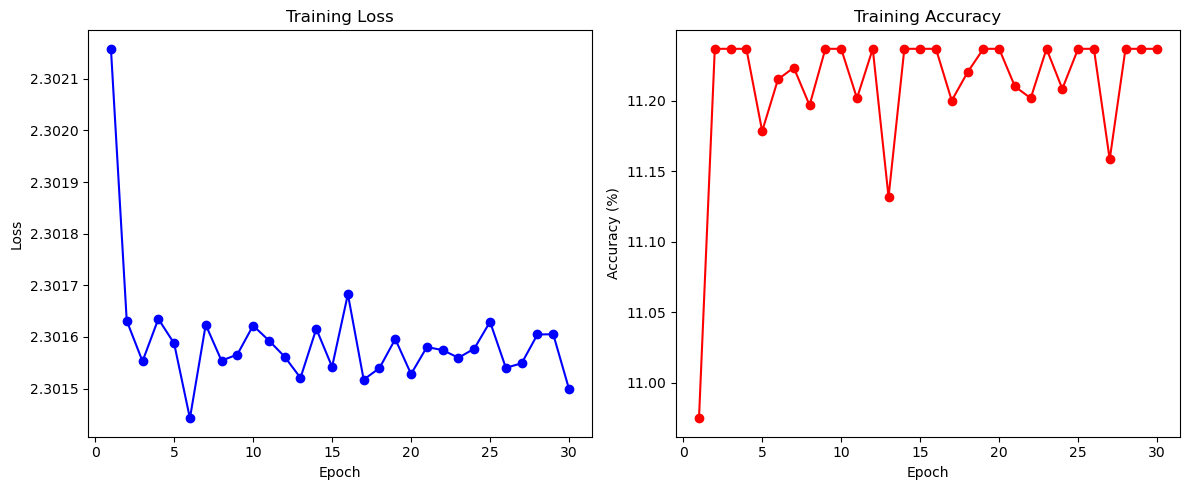

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt  # For plotting
import numpy as np
from scipy.optimize import curve_fit

# Hyperparameters
num_epochs = 30
batch_size = 64
learning_rate = 0.01

# Define the custom ReLU-like activation function
class CustomReLU(nn.Module):
    def __init__(self, a=1.0, b=0.0, c=0.0):
        super(CustomReLU, self).__init__()
        self.a = a
        self.b = b
        self.c = c

    def forward(self, x):
        return self.a * torch.maximum(torch.tensor(0.0, device=x.device), x - self.b) + self.c

# Create a simple three-layer neural network with normalization
class SimpleNN(nn.Module):
    def __init__(self, input_size=144, hidden_size=25, num_classes=10, a=1.0, b=0.0, c=0.0):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.custom_relu = CustomReLU(a, b, c)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Normalize input to range [0, 1] before activation
        x = self.fc1(x)

        # Apply nonlinear activation
        x = self.custom_relu(x)

        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Fit curve to get parameter values
def relu_like_function(x, a, b, c):
    return a * np.maximum(0, x - b) + c

# Extract the fitted parameters for use in the custom ReLU activation function
a, b, c = popt_Omega_2
print(f"Fitted parameters: a = {a:.4f}, b = {b:.4f}, c = {c:.4f}")

# Instantiate the model with the fitted parameters
model = SimpleNN(a=a, b=b, c=c)
print(model)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# MNIST dataset with resized images
transform = transforms.Compose([
    transforms.Resize((12, 12)),  # Resize to 12x12 pixels
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transform,
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=False,
                                          transform=transform)

# Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

# Loss and optimizer
criterion = nn.NLLLoss()  # Negative Log-Likelihood Loss for log_softmax output

# Define the SGD optimizer with momentum
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Lists to store loss and accuracy
train_losses = []
train_accuracies = []

# Training loop
total_step = len(train_loader)
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    correct = 0
    total = 0
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.view(-1, 12*12).to(device)  # Flatten the images
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Backward and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for the epoch
    avg_loss = running_loss / total_step
    accuracy = 100 * correct / total

    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Loss: {avg_loss:.4f}, '
          f'Accuracy: {accuracy:.2f}%')

# Testing the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.view(-1, 12*12).to(device)  # Flatten the images
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f'Test Accuracy of the model on the 10,000 test images: {test_accuracy:.2f}%')

# Save the model checkpoint (optional)
torch.save(model.state_dict(), 'simple_nn_resized.ckpt')

# Plotting the loss and accuracy graphs
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'r-o')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()


In [49]:
# store the loss and accuracy values
eit_train_losses = train_losses
eit_train_accuracies = train_accuracies

SimpleNN(
  (fc1): Linear(in_features=144, out_features=25, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=25, out_features=10, bias=True)
)
Epoch [1/30], Loss: 0.3824, Accuracy: 88.85%
Epoch [2/30], Loss: 0.2258, Accuracy: 93.34%
Epoch [3/30], Loss: 0.1909, Accuracy: 94.21%
Epoch [4/30], Loss: 0.1742, Accuracy: 94.81%
Epoch [5/30], Loss: 0.1620, Accuracy: 95.11%
Epoch [6/30], Loss: 0.1531, Accuracy: 95.31%
Epoch [7/30], Loss: 0.1486, Accuracy: 95.45%
Epoch [8/30], Loss: 0.1440, Accuracy: 95.67%
Epoch [9/30], Loss: 0.1376, Accuracy: 95.80%
Epoch [10/30], Loss: 0.1365, Accuracy: 95.88%
Epoch [11/30], Loss: 0.1325, Accuracy: 96.00%
Epoch [12/30], Loss: 0.1310, Accuracy: 96.08%
Epoch [13/30], Loss: 0.1287, Accuracy: 96.08%
Epoch [14/30], Loss: 0.1284, Accuracy: 96.12%
Epoch [15/30], Loss: 0.1253, Accuracy: 96.24%
Epoch [16/30], Loss: 0.1237, Accuracy: 96.27%
Epoch [17/30], Loss: 0.1213, Accuracy: 96.32%
Epoch [18/30], Loss: 0.1203, Accuracy: 96.29%
Epoch [19/30], Loss: 0.1195, Ac

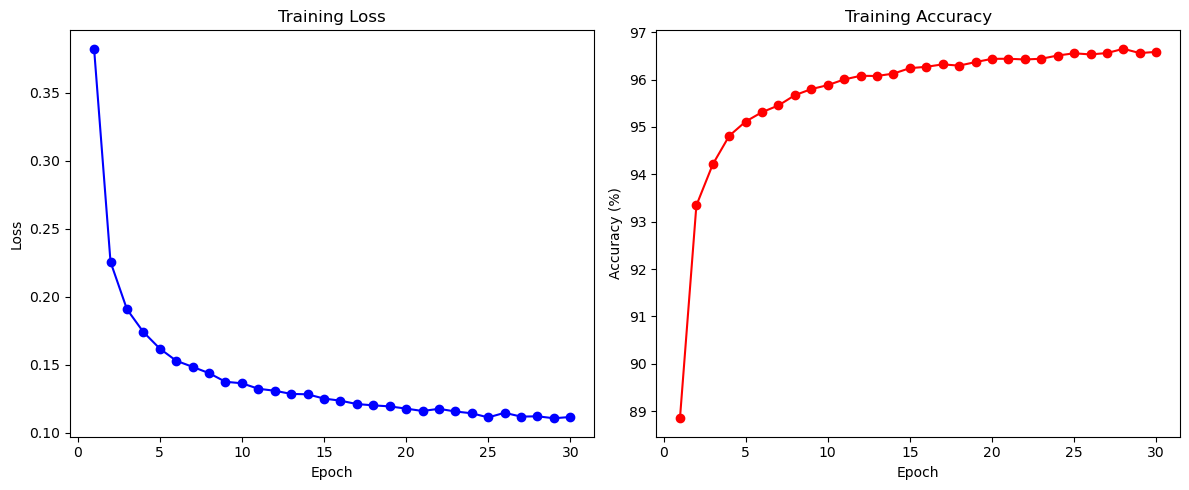

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt  # For plotting

# Create a simple three-layer neural network using standard ReLU
class SimpleNN(nn.Module):
    def __init__(self, input_size=144, hidden_size=25, num_classes=10):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()  # Standard ReLU activation
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)  # Apply standard ReLU activation
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Instantiate the model
model = SimpleNN()
print(model)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Hyperparameters
num_epochs = 30
batch_size = 64
learning_rate = 0.01

# MNIST dataset with resized images
transform = transforms.Compose([
    transforms.Resize((12, 12)),  # Resize to 12x12 pixels
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transform,
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=False,
                                          transform=transform)

# Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

# Loss and optimizer
criterion = nn.NLLLoss()  # Negative Log-Likelihood Loss for log_softmax output
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store loss and accuracy
train_losses = []
train_accuracies = []

# Training loop
total_step = len(train_loader)
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    correct = 0
    total = 0
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.view(-1, 12*12).to(device)  # Flatten the images
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Backward and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for the epoch
    avg_loss = running_loss / total_step
    accuracy = 100 * correct / total

    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Loss: {avg_loss:.4f}, '
          f'Accuracy: {accuracy:.2f}%')

# Testing the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.view(-1, 12*12).to(device)  # Flatten the images
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f'Test Accuracy of the model on the 10,000 test images: {test_accuracy:.2f}%')

# Save the model checkpoint (optional)
torch.save(model.state_dict(), 'simple_nn_relu.ckpt')

# Plotting the loss and accuracy graphs
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'r-o')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()


In [26]:
standard_loss = train_losses
standard_accuracy = train_accuracies

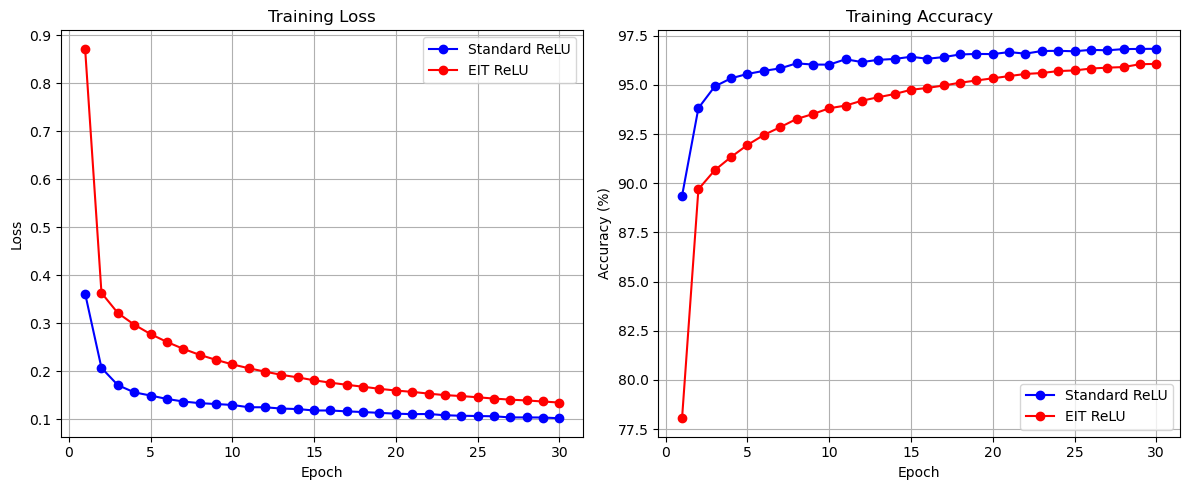

In [50]:
# plotting both loss and accuracies in the same figure
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, standard_loss, 'b-o', label='Standard ReLU')
plt.plot(epochs, eit_train_losses, 'r-o', label='EIT ReLU')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, standard_accuracy, 'b-o', label='Standard ReLU')
plt.plot(epochs, eit_train_accuracies, 'r-o', label='EIT ReLU')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


## Consider the Weak Probe Approximation Method

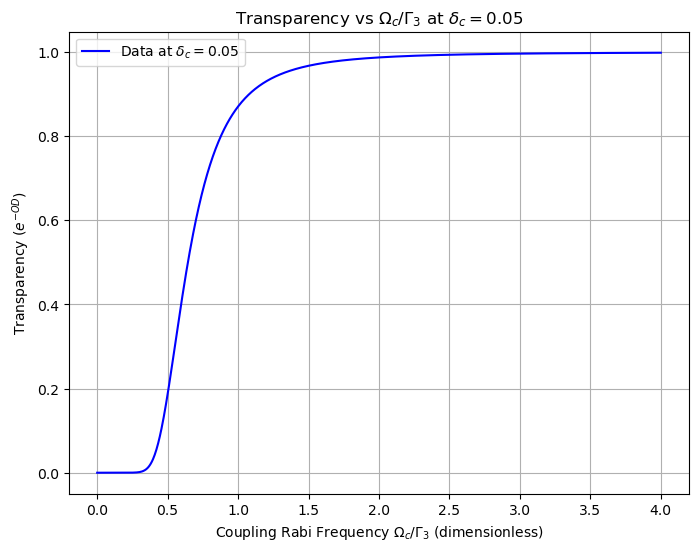

Fitted parameters:
A = 0.9840630676527912
k = 7.968059634951866
x0 = 0.6675498487546461


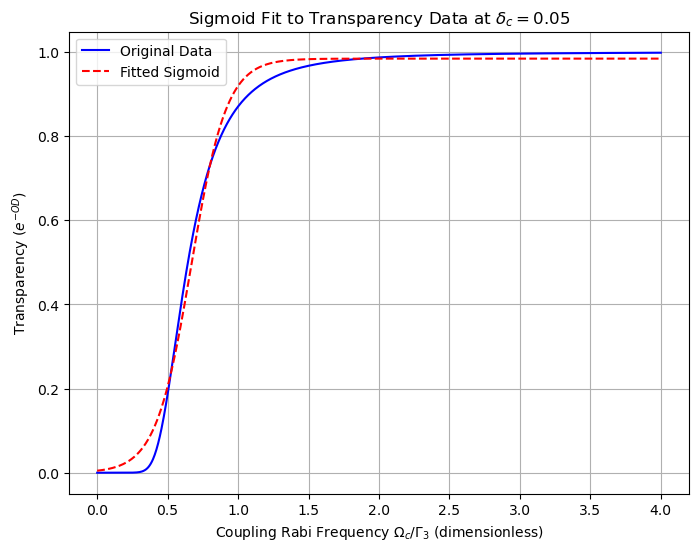

R-squared: 0.9945322403755275


In [59]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Constants (same as before)
epsilon_0 = 8.854e-12  # Vacuum permittivity (F/m)
hbar = 1.054e-34       # Reduced Planck's constant (J·s)
mu_13 = 1.932e-29      # Dipole moment between states |1> and |3> (C·m)
N = 7e8                # Atomic number density for cold atoms

Gamma3 = 2 * np.pi * 6   # (MHz)
Gamma31 = 5/9 * Gamma3   # Decay from level 3 to level 1 (MHz)
Gamma32 = 4/9 * Gamma3   # Decay from level 3 to level 2 (MHz)
Gamma12 = Gamma21 = 0    # Decay rates between levels 1 and 2 (MHz)
gamma13 = (Gamma3 + Gamma12)/2  # Decoherence rate between levels 1 and 3 (MHz)
gamma23 = (Gamma3 + Gamma21)/2  # Decoherence rate between levels 2 and 3 (MHz)
gamma12 = 0.001 * Gamma3        # Decoherence rate between ground states (MHz)

w_p = 2 * np.pi * 3e8 / 795e-9
k_0 = w_p / 3e8
L = 0.1

# Function to calculate OD and transparency
def calculate_transparency(Om_p, delta_p, delta_c):
    Om_c_list = np.linspace(0, 4, 1000)  # Coupling Rabi frequency range (MHz)
    T_1_values = []

    for Om_c_scaled in Om_c_list:
        Om_c_actual = Om_c_scaled * Gamma3      # Convert to actual Omega_c in MHz
        Om_p_actual = Om_p * Gamma3             # Convert Om_p to MHz
        delta_p_actual = delta_p * Gamma3
        delta_c_actual = delta_c * Gamma3

        numerator = 2 * Om_p_actual * (delta_p_actual - delta_c_actual + 1j * gamma12)
        denominator = (Om_c_actual * np.conj(Om_c_actual) - 4 * (delta_p_actual - delta_c_actual + 1j * gamma12) * (delta_p_actual + 1j * gamma13))
        rho31 = numerator / denominator

        # Calculate chi
        chi = (2 * N * rho31 * mu_13**2) / (epsilon_0 * hbar * Om_p_actual)

        # Calculate OD
        OD = k_0 * np.imag(chi) * L

        # Calculate the transparency
        T_1 = np.exp(-OD)
        T_1_values.append(T_1)

    return Om_c_list, T_1_values

# Parameters
Om_p = 0.001
delta_p = 0.0
delta_c = 0.05  # Fixed delta_c

# Generate data
Om_c_list, T_1_values = calculate_transparency(Om_p, delta_p, delta_c)

# Convert lists to NumPy arrays
Om_c_array = np.array(Om_c_list)
T_1_array = np.array(T_1_values)

# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(Om_c_array, T_1_array, 'b-', label=f'Data at $\delta_c = {delta_c}$')
plt.xlabel('Coupling Rabi Frequency $\Omega_c/\Gamma_3$ (dimensionless)')
plt.ylabel('Transparency ($e^{-OD}$)')
plt.title('Transparency vs $\Omega_c/ \Gamma_3$ at $\delta_c = 0.05$')
plt.legend()
plt.grid(True)
plt.show()

# Define the modified sigmoid function with y0 fixed at 0
def sigmoid(x, A, k, x0):
    return A / (1 + np.exp(-k * (x - x0)))

# Initial guess for the parameters [A, k, x0]
initial_guess = [1, 1, 2]

# Set bounds for the parameters: A between 0 and 1, k >= 0, x0 >= 0
bounds = ([0, 0, 0], [1, np.inf, np.inf])

# Fit the sigmoid function to the data
popt, pcov = curve_fit(sigmoid, Om_c_array, T_1_array, p0=initial_guess, bounds=bounds, maxfev=10000)

# Extract the optimal parameters
A_opt, k_opt, x0_opt = popt
print(f"Fitted parameters:\nA = {A_opt}\nk = {k_opt}\nx0 = {x0_opt}")

# Generate fitted data using the optimal parameters
T_1_fitted = sigmoid(Om_c_array, *popt)

# Ensure that the fitted values are not negative
T_1_fitted = np.clip(T_1_fitted, 0, None)

# Plot the original data and the fitted sigmoid function
plt.figure(figsize=(8, 6))
plt.plot(Om_c_array, T_1_array, 'b-', label='Original Data')
plt.plot(Om_c_array, T_1_fitted, 'r--', label='Fitted Sigmoid')
plt.xlabel('Coupling Rabi Frequency $\Omega_c/\Gamma_3$ (dimensionless)')
plt.ylabel('Transparency ($e^{-OD}$)')
plt.title('Sigmoid Fit to Transparency Data at $\delta_c = 0.05$')
plt.legend()
plt.grid(True)
plt.show()

# Calculate R-squared to assess the fit
residuals = T_1_array - T_1_fitted
ss_res = np.sum(residuals**2)
ss_tot = np.sum((T_1_array - np.mean(T_1_array))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R-squared: {r_squared}")


Fitted parameters: A = 0.9841, k = 7.9681, x0 = 0.6675
SimpleNN(
  (fc1): Linear(in_features=144, out_features=25, bias=True)
  (custom_sigmoid): CustomSigmoid()
  (fc2): Linear(in_features=25, out_features=10, bias=True)
)
Epoch [1/30], Loss: 1.2528, Accuracy: 67.24%
Epoch [2/30], Loss: 0.4435, Accuracy: 88.53%
Epoch [3/30], Loss: 0.3486, Accuracy: 90.31%
Epoch [4/30], Loss: 0.3092, Accuracy: 91.13%
Epoch [5/30], Loss: 0.2837, Accuracy: 91.81%
Epoch [6/30], Loss: 0.2647, Accuracy: 92.30%
Epoch [7/30], Loss: 0.2491, Accuracy: 92.66%
Epoch [8/30], Loss: 0.2370, Accuracy: 93.06%
Epoch [9/30], Loss: 0.2279, Accuracy: 93.36%
Epoch [10/30], Loss: 0.2201, Accuracy: 93.57%
Epoch [11/30], Loss: 0.2128, Accuracy: 93.81%
Epoch [12/30], Loss: 0.2068, Accuracy: 93.93%
Epoch [13/30], Loss: 0.2018, Accuracy: 94.04%
Epoch [14/30], Loss: 0.1969, Accuracy: 94.23%
Epoch [15/30], Loss: 0.1922, Accuracy: 94.30%
Epoch [16/30], Loss: 0.1881, Accuracy: 94.46%
Epoch [17/30], Loss: 0.1839, Accuracy: 94.55%
Epo

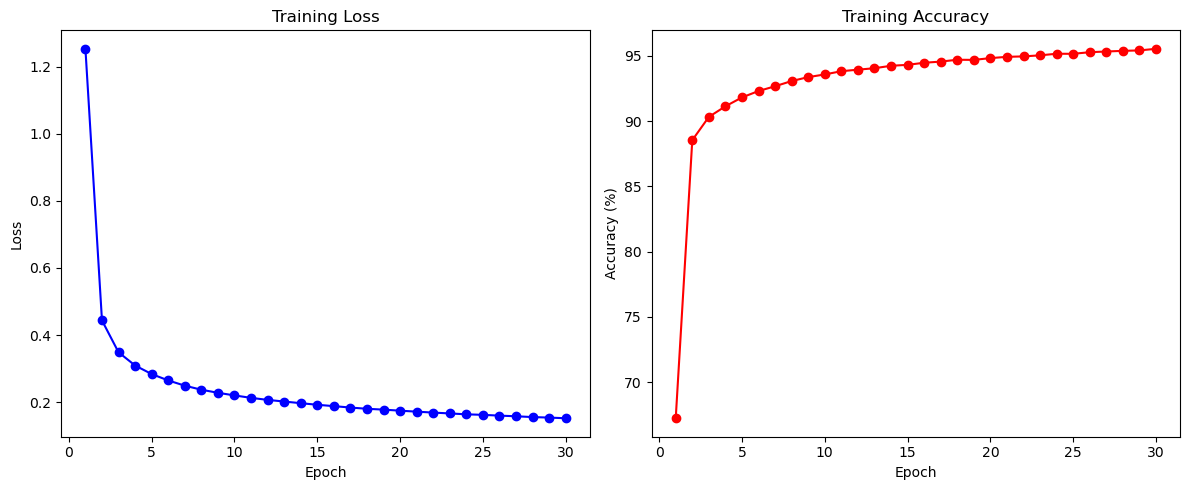

In [60]:
# Define the custom sigmoid activation function
class CustomSigmoid(nn.Module):
    def __init__(self, A, k, x0):
        super(CustomSigmoid, self).__init__()
        self.A = A
        self.k = k
        self.x0 = x0

    def forward(self, x):
        return self.A / (1 + torch.exp(-self.k * (x - self.x0)))
    
# Create a simple three-layer neural network with the new activation function
class SimpleNN(nn.Module):
    def __init__(self, input_size=144, hidden_size=25, num_classes=10, A=1.0, k=1.0, x0=0.0):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.custom_sigmoid = CustomSigmoid(A, k, x0)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # First linear layer
        x = self.fc1(x)

        # Apply custom sigmoid activation
        x = self.custom_sigmoid(x)

        # Second linear layer and output
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt  # For plotting
import numpy as np

# Hyperparameters
num_epochs = 30
batch_size = 64
learning_rate = 0.01

# Suppose these are your fitted sigmoid parameters from the curve fitting
A_opt = 0.9935   # Replace with your actual fitted A parameter
k_opt = 3.5678   # Replace with your actual fitted k parameter
x0_opt = 1.2345  # Replace with your actual fitted x0 parameter

A_opt, k_opt, x0_opt = popt

print(f"Fitted parameters: A = {A_opt:.4f}, k = {k_opt:.4f}, x0 = {x0_opt:.4f}")

# Define the custom sigmoid activation function
class CustomSigmoid(nn.Module):
    def __init__(self, A, k, x0):
        super(CustomSigmoid, self).__init__()
        self.A = A
        self.k = k
        self.x0 = x0

    def forward(self, x):
        return self.A / (1 + torch.exp(-self.k * (x - self.x0)))

# Create a simple three-layer neural network with the new activation function
class SimpleNN(nn.Module):
    def __init__(self, input_size=144, hidden_size=25, num_classes=10, A=1.0, k=1.0, x0=0.0):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.custom_sigmoid = CustomSigmoid(A, k, x0)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # First linear layer
        x = self.fc1(x)

        # Apply custom sigmoid activation
        x = self.custom_sigmoid(x)

        # Second linear layer and output
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Instantiate the model with the fitted parameters
model = SimpleNN(A=A_opt, k=k_opt, x0=x0_opt)
print(model)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# MNIST dataset with resized images
transform = transforms.Compose([
    transforms.Resize((12, 12)),  # Resize to 12x12 pixels
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transform,
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=False,
                                          transform=transform)

# Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

# Loss and optimizer
criterion = nn.NLLLoss()  # Negative Log-Likelihood Loss for log_softmax output

# Define the SGD optimizer with momentum
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Lists to store loss and accuracy
train_losses = []
train_accuracies = []

# Training loop
total_step = len(train_loader)
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    correct = 0
    total = 0
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.view(-1, 12*12).to(device)  # Flatten the images
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Backward and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for the epoch
    avg_loss = running_loss / total_step
    accuracy = 100 * correct / total

    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Loss: {avg_loss:.4f}, '
          f'Accuracy: {accuracy:.2f}%')

# Testing the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.view(-1, 12*12).to(device)  # Flatten the images
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f'Test Accuracy of the model on the 10,000 test images: {test_accuracy:.2f}%')

# Save the model checkpoint (optional)
torch.save(model.state_dict(), 'simple_nn_resized.ckpt')

# Plotting the loss and accuracy graphs
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'r-o')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()


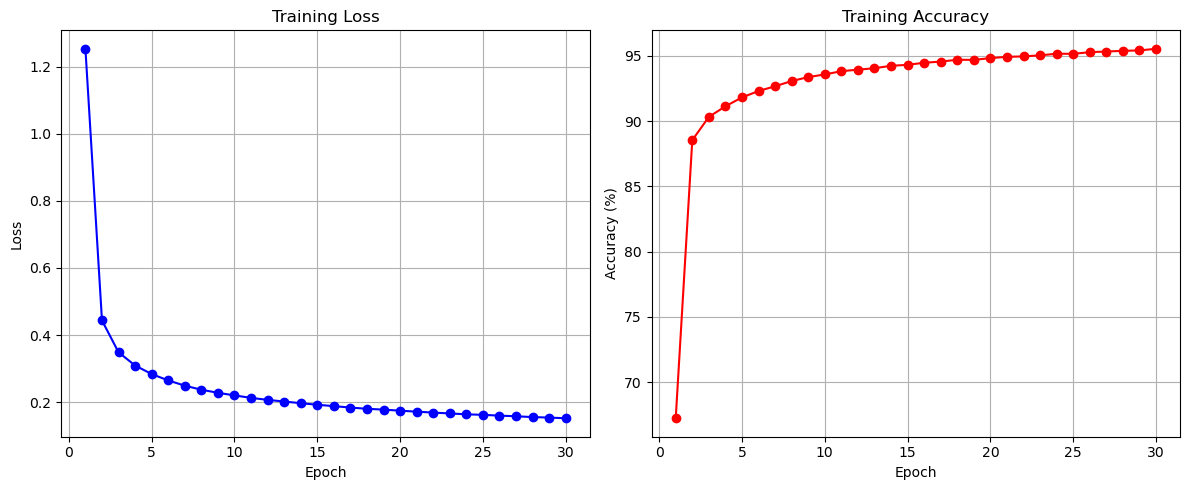

In [61]:
# Plotting the loss and accuracy graphs
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'r-o')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)

plt.tight_layout()
plt.show()